In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns
import scanpy as sc
import scipy.cluster.hierarchy as sch
import re

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=500, frameon=False)
sc.set_figure_params(dpi=500)
sc.set_figure_params(figsize=(4, 4))

In [3]:
# Please replace with actual data path
path = '../../data/Tcell_exhaustion/Tcell_exhaustion/FDR10/fimo_ko/'

In [4]:
# Load output from motif scanning
fimo = pd.read_csv(path + 'fimo.tsv', sep='\t')


In [5]:
# Preprocess fimo output
## Remove rows with missing values
fimo.dropna(subset=['sequence_name'], inplace=True)

## Extract chromosome and gene name
fimo['chrom'] = fimo['sequence_name'].str.split('_').str[1]
fimo['gene'] = fimo['sequence_name'].str.split('_').str[0]

## Remove seq name column
fimo.drop(columns=['sequence_name', 'motif_alt_id'], inplace=True)

## Convert motif to uppercase
fimo['motif_id'] = fimo['motif_id'].str.upper()

In [6]:
# Define function to summarize binding sites

def summarize_binding_sites(df):
    # Sort the DataFrame by genes, motif, strand, and start position
    sorted_df = df.sort_values(by=['gene', 'motif_id', 'strand', 'start'])

    # Initialize empty lists to store the summarized data
    genes = []
    starts = []
    ends = []
    motifs = []
    scores = []
    strands = []

    # Iterate over the sorted DataFrame and compute the summary statistics
    current_gene = None
    current_motif = None
    current_strand = None
    current_start = None
    current_end = None
    total_score = 0
    count = 0

    for _, row in sorted_df.iterrows():
        gene = row['gene']
        motif = row['motif_id']
        strand = row['strand']
        start = row['start']
        end = row['stop']
        score = row['score']

        # Check if it's a new group or if the current row overlaps with the previous one
        if gene != current_gene or motif != current_motif or strand != current_strand or start > current_end:
            # Append the summarized data to the lists
            if current_gene is not None:
                genes.append(current_gene)
                starts.append(current_start)
                ends.append(current_end)
                motifs.append(current_motif)
                scores.append(total_score / count)
                strands.append(current_strand)

            # Update the current group information
            current_gene = gene
            current_motif = motif
            current_strand = strand
            current_start = start
            current_end = end
            total_score = score
            count = 1
        else:
            # Update the end position and accumulate the score
            current_end = max(current_end, end)
            total_score += score
            count += 1

    # Append the last group
    if current_gene is not None:
        genes.append(current_gene)
        starts.append(current_start)
        ends.append(current_end)
        motifs.append(current_motif)
        scores.append(total_score / count)
        strands.append(current_strand)

    # Create a new DataFrame with the summarized data
    summary_df = pd.DataFrame({
        'symbols': genes,
        'start': starts,
        'end': ends,
        'motif': motifs,
        'score': scores,
        'strand': strands
    })

    return summary_df

In [7]:
summary_fimo = summarize_binding_sites(fimo)
summary_fimo

,symbols,start,end,motif,score,strand
0,1700019D03Rik,53020444.0,53020452.0,ARID3A,8.89349,-
1,1700019D03Rik,53019792.0,53019802.0,ARID3B,14.45560,+
2,1700019D03Rik,53021012.0,53021022.0,ARID3B,13.06670,+
3,1700019D03Rik,53019812.0,53019822.0,ARID3B,13.15560,-
4,1700019D03Rik,53021011.0,53021021.0,ARID3B,13.06670,-
...,...,...,...,...,...,...
89429,Zyx,42349504.0,42349518.0,ZFP281,14.03200,+
89430,Zyx,42349980.0,42349994.0,ZFP281,13.54400,+
89431,Zyx,42349532.0,42349548.0,ZFP410,13.49550,-
89432,Zyx,42348225.0,42348241.0,ZFP691,13.73000,-


In [40]:
summary_fimo.to_csv(path + 'summary_fimo.tsv', sep='\t', index=False)

In [9]:
# Create count matrix from the summarized FIMO data

def create_tf_gene_matrix(df):
    """
    Create a TF-gene matrix as a pandas DataFrame where the value represents 
    how often a gene appears as a target of a given TF.

    Parameters:
    - df (pd.DataFrame): A DataFrame with columns ['symbols', 'motif'],
                         where each row represents a TF binding event.

    Returns:
    - tf_gene_df (pd.DataFrame): A DataFrame of shape (num_TFs, num_genes) 
                                 with counts of TF-gene interactions.
    """
    # Count occurrences of (TF, gene) pairs
    interaction_counts = df.groupby(["motif", "symbols"]).size().unstack(fill_value=0).T

    return interaction_counts

In [10]:
count_matrix = create_tf_gene_matrix(summary_fimo)
count_matrix.sort_index(inplace=True, axis=1)
count_matrix

motif,AHCTF1,AHR,AR,ARID3A,ARID3B,ARID5A,ARID5B,ARNT,ARNTL,ATF1,...,ZBTB6,ZBTB7B,ZFP128,ZFP281,ZFP335,ZFP410,ZFP652,ZFP691,ZFP740,ZFX
symbols,,,,,,,,,,,,,,,,,,,,,
1700019D03Rik,0,0,0,1,4,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
1700025G04Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,5
1810026B05Rik,0,0,0,0,0,0,0,0,0,0,...,1,0,0,2,0,0,0,0,0,5
4930417O13Rik,1,0,0,2,4,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4930453N24Rik,0,0,0,0,1,2,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zmiz1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,2,0,0,0,2
Znrf2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
Znrf3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3


In [16]:
count_matrix.to_csv(path + 'count_matrix.tsv', sep='\t')

/home/lorna/miniconda3/envs/gretabench/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


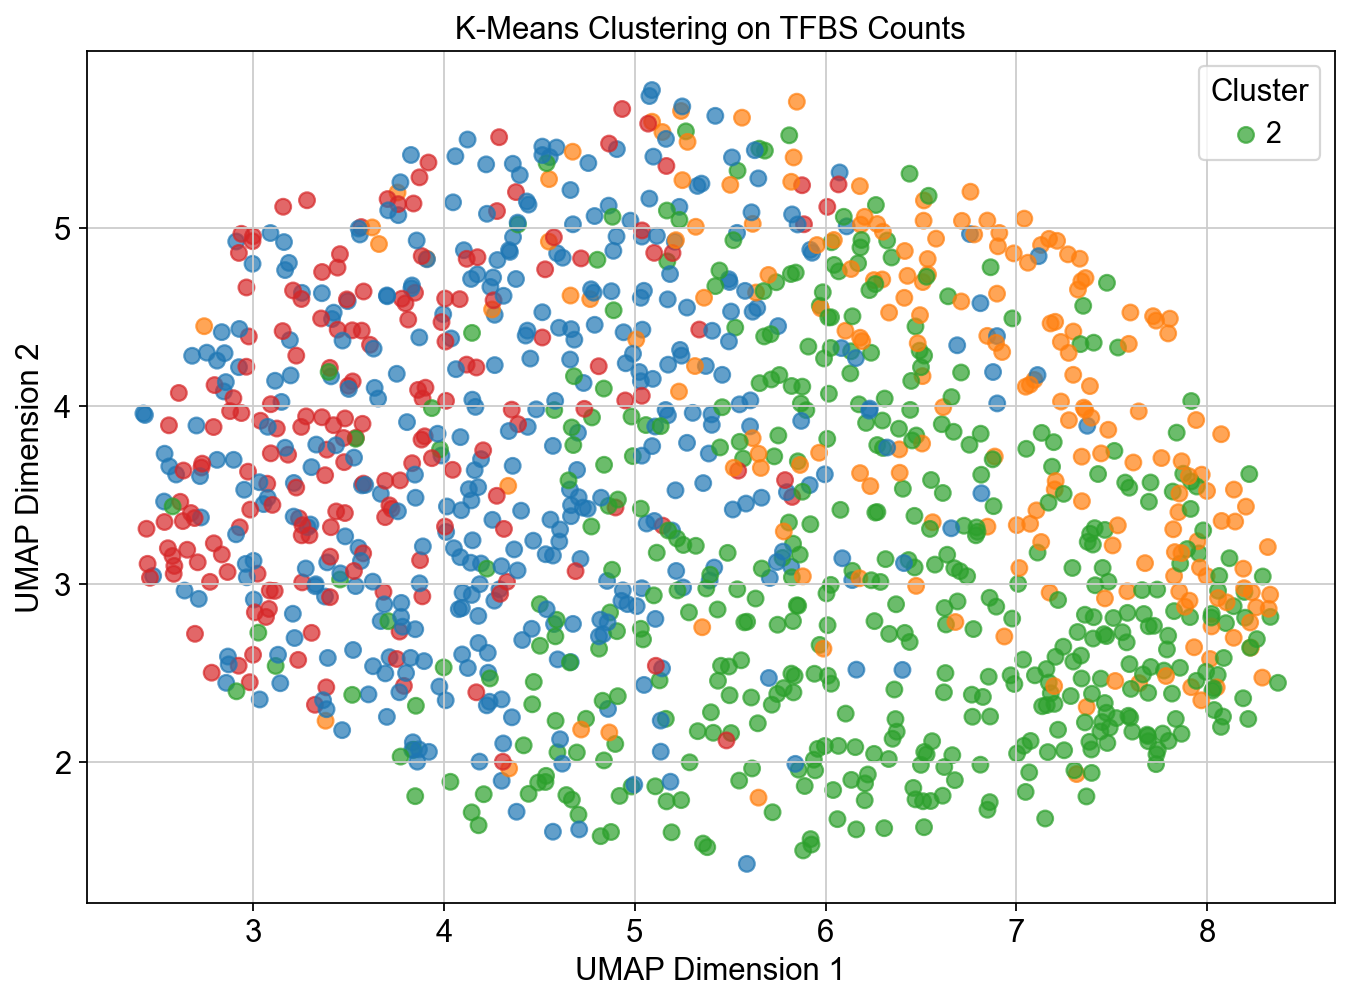

In [11]:
n_clusters = 4  # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(count_matrix)
df_labels = pd.DataFrame()

# Add labels to DataFrame
df_labels['Cluster'] = labels

#Dimensionality Reduction with UMAP
umap = UMAP(n_components=2, random_state=42, metric='canberra')
embedding = umap.fit_transform(count_matrix)


palette = sns.color_palette("tab10", n_clusters)  # Choose a palette with n_clusters colors
colors = [palette[label] for label in labels]

#Visualize the Clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    embedding[:, 0], embedding[:, 1], 
    c=colors, s=50, alpha=0.7
)
plt.title("K-Means Clustering on TFBS Counts")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.savefig(path + 'Kmeans_count_matrix_umap_k4.png')
plt.legend(title='Cluster', loc='upper right', labels=labels)
plt.show()

In [131]:
# Save the cluster assignments to a file
for i in cosine_dist_df['Cluster'].unique():
    pd.Series(cosine_dist_df[cosine_dist_df['Cluster'] == i].index).to_csv(path + f'Count_cluster{i}_genes_k4.tsv', sep='\t', index=False)
 
